In [1]:
import commons
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
input_file = 'autotagging_moodtheme.tsv'
tracks, tags, extra = commons.read_file(input_file)

Reading: 18486 tracks, 4506 albums, 1533 artists


In [3]:
# Get the first key-value pair and print it
first_pair = list(tracks.items())[0]
print(first_pair)

(948, {'artist_id': 87, 'album_id': 149, 'path': '48/948.mp3', 'duration': 212.7, 'tags': ['mood/theme---background'], 'genre': set(), 'instrument': set(), 'mood/theme': {'background'}})


In [4]:
# delete genre and instrument from dictionary
for key in tracks:
    tracks[key].pop('genre', None)
    tracks[key].pop('instrument', None)
    tracks[key].pop('tags', None)

In [5]:
# transform into dataframe
# df_labels = pd.DataFrame.from_dict(tracks, orient='index').reset_index()
# df_labels = df_labels.rename(columns={'index': 'track_id'})
# print(df_labels.head())

In [6]:
# save dataframe to csv in my own folder
# folder_path = "C:/Users/marce/OneDrive/Dokumente/Master/CBS/2nd semester/ML/Project/Music"
# file_path = folder_path + '/autotagging_moodtheme_transformed.csv'
# df_labels.to_csv(file_path, index=False)

## EDA of labels dataset

In [7]:
# Count number of tracks per label

moods = []
for track in tracks.values():
    moods.extend(list(track['mood/theme']))

print(moods[:10])

['background', 'background', 'background', 'film', 'melancholic', 'calm', 'melodic', 'calm', 'melodic', 'calm']


In [8]:
print('There are', len(set(moods)), 'mood/theme labels.')

There are 59 mood/theme labels.


In [9]:
# number of tracks per label
label_counts = pd.Series(moods).value_counts()
label_counts = pd.DataFrame({'Label': label_counts.index, 'Count': label_counts.values})
print(label_counts)

           Label  Count
0          happy   1657
1           film   1502
2      energetic   1357
3       relaxing   1350
4      emotional   1271
5        melodic   1213
6           dark   1202
7           epic    982
8          dream    951
9           love    909
10     inspiring    877
11           sad    749
12    meditative    742
13     uplifting    693
14   advertising    673
15  motivational    635
16          deep    635
17      romantic    627
18     christmas    623
19   documentary    612
20     corporate    609
21      positive    539
22        summer    505
23         space    503
24    background    496
25           fun    480
26    soundscape    480
27          soft    465
28     ambiental    460
29          calm    457
30      children    456
31     adventure    448
32        upbeat    444
33   melancholic    441
34          slow    437
35    commercial    428
36         drama    424
37         movie    413
38        action    407
39        ballad    334
40      dramatic

As our project focuses on music emotion recognition (MER), we simplify the task by dropping theme labels. This has two benefits:
- We avoid introducing additional irrelevant factors that could potentially affect the accuracy of your model.  
- We reduce the complexity of the analysis and make it easier to interpret the results.

To identify which of the labels can be regarded as emotions, we used the 'wheel of emotions' proposed by Robert Plutchik (2001).

Plutchik, R. (2001). The Nature of Emotions: Human emotions have deep evolutionary roots, a fact that may explain their complexity and provide tools for clinical practice. *American Scientist, 89*(4), 344–350.

Based on his model, the labels considered emotions are: 'inspiring', 'energetic', 'happy', 'sad', 'motivational', 'relaxing', 'uplifting', 'calm', 'love','hopeful'.

The labels not considered emotions are: 'summer', 'holiday', 'emotional', 'film', 'action', 'heavy', 'christmas', 'groovy', 'soundscape', 'cool', 'fast', 'nature', 'drama', 'ambiental', 'retro', 'funny', 'fun', 'game', 'documentary', 'dark', 'dream', 'sexy', 'epic', 'ballad', 'sport', 'corporate', 'children', 'travel', 'party', 'positive', 'advertising', 'soft', 'romantic', 'meditative', 'adventure', 'space', 'horror', 'movie', 'trailer', 'deep', 'commercial', 'dramatic', 'mellow', 'upbeat', 'powerful'.

In [10]:
# drop theme labels, only keep emotion labels
emotions = ['inspiring', 'energetic', 'happy', 'sad', 'motivational', 'relaxing', 'uplifting', 'calm', 'love','hopeful']
labels_emotions = list(filter(lambda x: x in emotions, moods))
print(labels_emotions[:10])

['calm', 'calm', 'calm', 'calm', 'calm', 'relaxing', 'relaxing', 'relaxing', 'relaxing', 'relaxing']


In [11]:
# number of tracks per emotion label
emotion_counts_s = pd.Series(labels_emotions).value_counts()
emotion_counts_df = pd.DataFrame({'emotion': emotion_counts_s.index, 'Count': emotion_counts_s.values})
print(emotion_counts_df)

        emotion  Count
0         happy   1657
1     energetic   1357
2      relaxing   1350
3          love    909
4     inspiring    877
5           sad    749
6     uplifting    693
7  motivational    635
8          calm    457
9       hopeful    216


In [21]:
emotion_counts_df['Percentage'] = emotion_counts_df['Count'] / emotion_counts_df['Count'].sum()
print(emotion_counts_df)

        emotion  Count  Percentage
0         happy   1657    0.186180
1     energetic   1357    0.152472
2      relaxing   1350    0.151685
3          love    909    0.102135
4     inspiring    877    0.098539
5           sad    749    0.084157
6     uplifting    693    0.077865
7  motivational    635    0.071348
8          calm    457    0.051348
9       hopeful    216    0.024270


In [24]:
print('Total number of labels:',sum(emotion_counts_df["Count"]))

Total number of labels: 8900


In [25]:
print('Expected accuracy (weighted average of percentages):', 
      sum(emotion_counts_df['Percentage']) / len(emotion_counts_df))

Expected accuracy (weighted average of percentages): 0.1


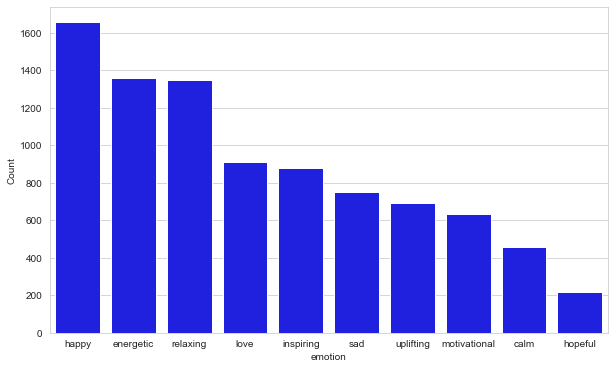

In [13]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.barplot(data=emotion_counts_df, x="emotion", y="Count", color='blue')
plt.show()

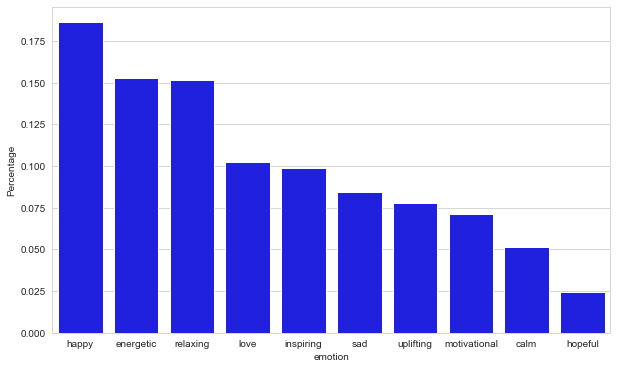

In [22]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.barplot(data=emotion_counts_df, x="emotion", y="Percentage", color='blue')
plt.show()

In [14]:
# drop labels not considered emotions from dataset and delete entries that do not have any labels left 

keys_to_delete = []

for key, value in tracks.items():
    value['mood/theme'] = value['mood/theme'].intersection(emotions)
    if not value['mood/theme']:
        keys_to_delete.append(key)

for key in keys_to_delete:
    del tracks[key]

In [15]:
print(list(tracks.items())[:10])

[(3346, {'artist_id': 517, 'album_id': 521, 'path': '46/3346.mp3', 'duration': 195.0, 'mood/theme': {'calm'}}), (3347, {'artist_id': 517, 'album_id': 521, 'path': '47/3347.mp3', 'duration': 201.8, 'mood/theme': {'calm'}}), (3348, {'artist_id': 517, 'album_id': 521, 'path': '48/3348.mp3', 'duration': 253.3, 'mood/theme': {'calm'}}), (3349, {'artist_id': 517, 'album_id': 521, 'path': '49/3349.mp3', 'duration': 228.4, 'mood/theme': {'calm'}}), (3350, {'artist_id': 517, 'album_id': 521, 'path': '50/3350.mp3', 'duration': 194.7, 'mood/theme': {'calm'}}), (4639, {'artist_id': 87, 'album_id': 718, 'path': '39/4639.mp3', 'duration': 188.0, 'mood/theme': {'relaxing'}}), (6253, {'artist_id': 811, 'album_id': 960, 'path': '53/6253.mp3', 'duration': 271.8, 'mood/theme': {'relaxing'}}), (6254, {'artist_id': 811, 'album_id': 960, 'path': '54/6254.mp3', 'duration': 481.6, 'mood/theme': {'relaxing'}}), (6256, {'artist_id': 811, 'album_id': 960, 'path': '56/6256.mp3', 'duration': 236.5, 'mood/theme': {

In [16]:
print('The number of tracks left after only considering emotion labels is ' + str(len(tracks)) + '.')

The number of tracks left after only considering emotion labels is 7087.


In [17]:
# transform into dataframe
# df_labels_emotion = pd.DataFrame.from_dict(tracks, orient='index').reset_index()
# df_labels_emotion = df_labels_emotion.rename(columns={'index': 'track_id'})
# print(df_labels_emotion.head())

In [18]:
# # save dictionary as pickle file to current folder
# with open('tracks.pkl', 'wb') as f:
#     pickle.dump(tracks, f)